# Variance scanning based on sample directions

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

In [35]:
# Load 3D sample data from disk
def load_samples(sample_dir, iteration, max_num_samples=10000):
    position = np.load(f"{sample_dir}/position-{iteration}.npy")
    direction = np.load(f"{sample_dir}/direction-{iteration}.npy")
    weight = np.load(f"{sample_dir}/weight-{iteration}.npy")
    assert position.shape[0] == direction.shape[0] == weight.shape[0]
    print(f"Loaded {position.shape[0]} samples")
    num_samples = min(max_num_samples, position.shape[0])
    selected_indices = np.random.choice(position.shape[0], num_samples, replace=False)
    position = position[selected_indices]
    direction = direction[selected_indices]
    weight = weight[selected_indices]
    print(f"Using {num_samples} samples")
    return position, direction, weight


source_dir = "/local/home/zhengfe/Thesis/PBRT-v4/results/vs"
spp = 2
position, direction, weight = load_samples(f"{source_dir}/cbox-classic/cbox-classic-samples-vs3d", spp, 10000)
roi = np.stack([np.min(position, axis=0), np.max(position, axis=0)], axis=1)

Loaded 94524 samples
Using 10000 samples


In [30]:
# Interactive roi selection
%matplotlib widget
from ipywidgets import AppLayout, FloatSlider, VBox, HBox

plt.close('all')
plt.ioff()

bounds = np.stack([position.min(axis=0), position.max(axis=0)], axis=1) # 3x2
extent = bounds[:, 1] - bounds[:, 0]
bounds += np.array([-0.05, 0.05])[None, :] * extent[:, None]
slider_xmin = FloatSlider(orientation='horizontal', value=roi[0, 0], min=bounds[0, 0], max=bounds[0, 1], step=0.01, description='xmin:')
slider_xmax = FloatSlider(orientation='horizontal', value=roi[0, 1], min=bounds[0, 0], max=bounds[0, 1], step=0.01, description='xmax:')
slider_ymin = FloatSlider(orientation='horizontal', value=roi[1, 0], min=bounds[1, 0], max=bounds[1, 1], step=0.01, description='ymin:')
slider_ymax = FloatSlider(orientation='horizontal', value=roi[1, 1], min=bounds[1, 0], max=bounds[1, 1], step=0.01, description='ymax:')
slider_zmin = FloatSlider(orientation='horizontal', value=roi[2, 0], min=bounds[2, 0], max=bounds[2, 1], step=0.01, description='zmin:')
slider_zmax = FloatSlider(orientation='horizontal', value=roi[2, 1], min=bounds[2, 0], max=bounds[2, 1], step=0.01, description='zmax:')

colors = np.abs(direction)
fig, (ax, axXOY, axZOY) = plt.subplots(1, 3, figsize=(13, 5))
ax.scatter(position[:, 0], position[:, 2], c=colors, s=2, alpha=0.2)
focusXOZ = ax.plot([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]], [roi[2, 0], roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0]], 'r--')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_aspect('equal')
axXOY.scatter(position[:, 0], position[:, 1], c=colors, s=2, alpha=0.2)
focusXOY = axXOY.plot([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]], [roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]], 'r--')
axXOY.set_xlabel('x')
axXOY.set_ylabel('y')
axXOY.set_aspect('equal')
axZOY.scatter(position[:, 2], position[:, 1], c=colors, s=2, alpha=0.2)
focusZOY = axZOY.plot([roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0], roi[2, 0]], [roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]], 'r--')
axZOY.set_xlabel('z')
axZOY.set_ylabel('y')
axZOY.set_aspect('equal')
plt.tight_layout()

def make_callback(i, j):
    def update_focus(change):
        roi[i, j] = change.new
        focusXOZ[0].set_xdata([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]])
        focusXOZ[0].set_ydata([roi[2, 0], roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0]])
        focusXOY[0].set_xdata([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]])
        focusXOY[0].set_ydata([roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]])
        focusZOY[0].set_xdata([roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0], roi[2, 0]])
        focusZOY[0].set_ydata([roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]])
        fig.canvas.draw()
        # fig.canvas.flush_events()
    return update_focus

slider_xmin.observe(make_callback(0, 0), names='value')
slider_xmax.observe(make_callback(0, 1), names='value')
slider_ymin.observe(make_callback(1, 0), names='value')
slider_ymax.observe(make_callback(1, 1), names='value')
slider_zmin.observe(make_callback(2, 0), names='value')
slider_zmax.observe(make_callback(2, 1), names='value')

for slider in [slider_xmin, slider_xmax, slider_ymin, slider_ymax, slider_zmin, slider_zmax]:
    slider.layout.width = '40%'

AppLayout(
    center=fig.canvas,
    footer=VBox([HBox([slider_xmin, slider_xmax]), HBox([slider_ymin, slider_ymax]), HBox([slider_zmin, slider_zmax])]),
)

AppLayout(children=(VBox(children=(HBox(children=(FloatSlider(value=-1.0000003576278687, description='xmin:', …

ROI: [[-0.8200004   0.10999962]
 [ 0.6999996   1.2899996 ]
 [-0.8098741   0.16012587]]
Selected 1277 samples


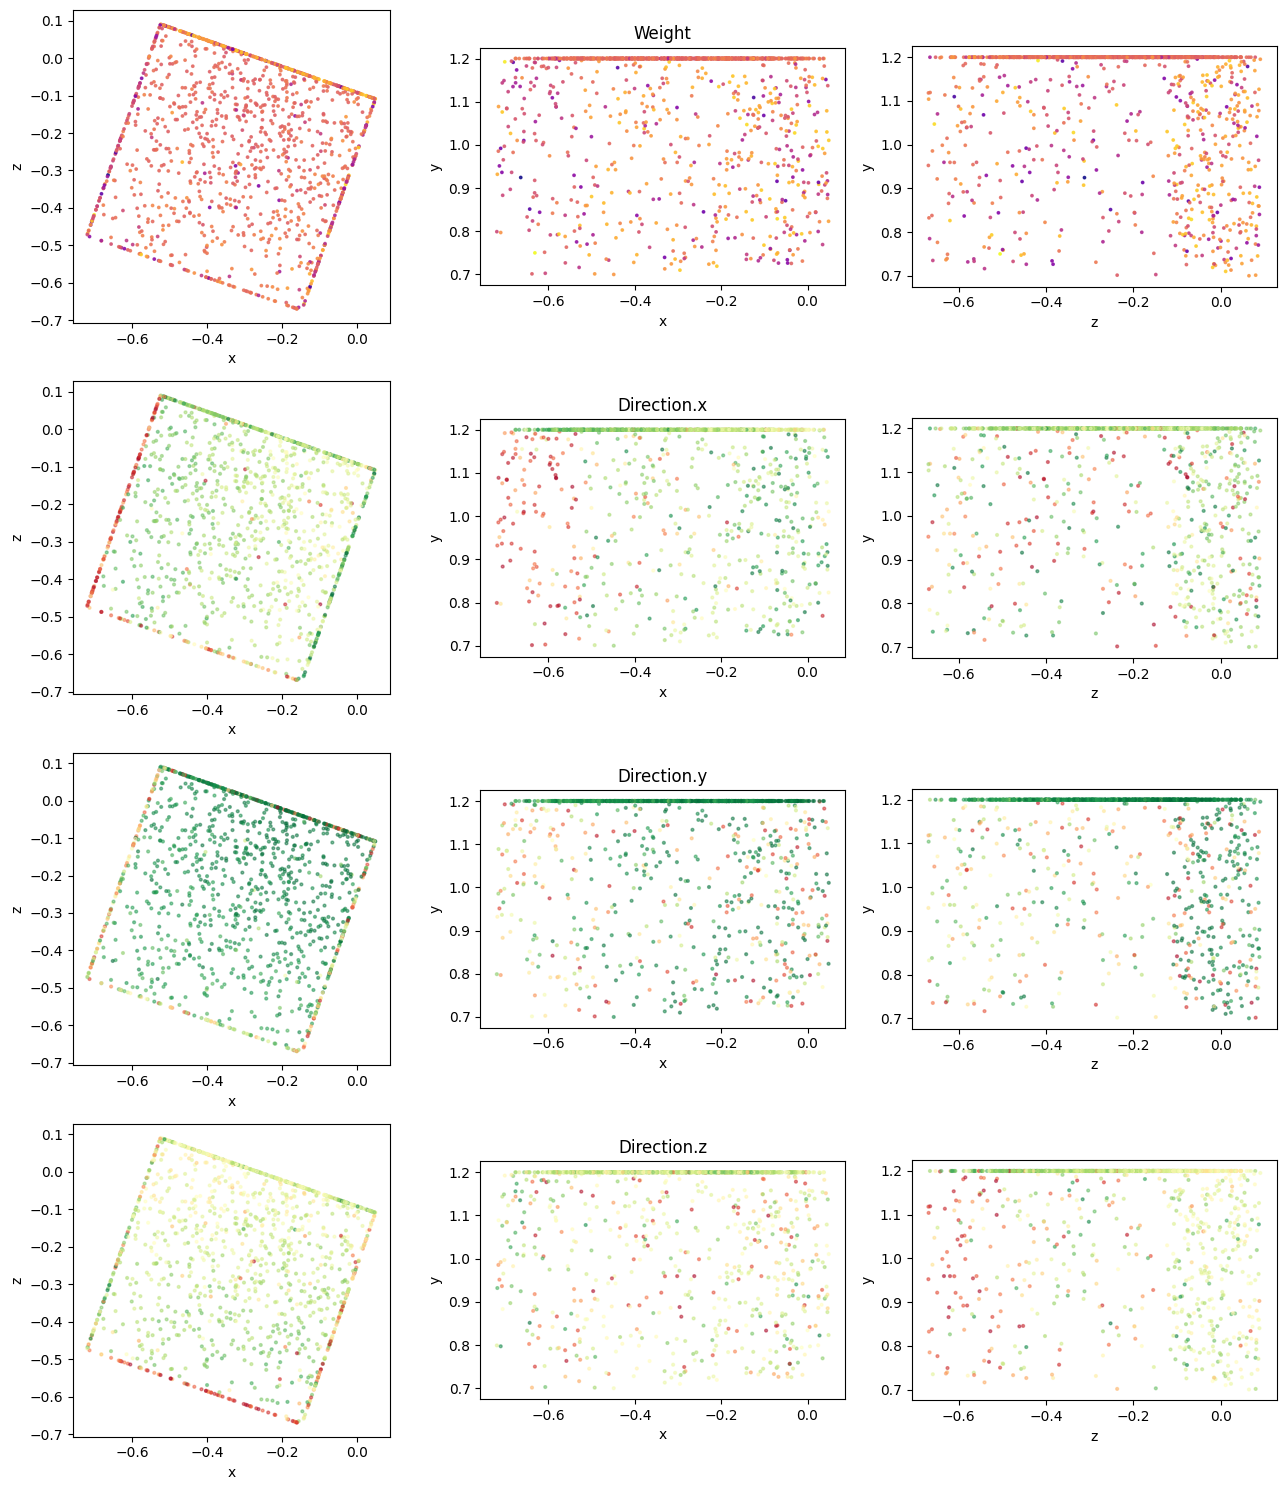

In [36]:
# Plot the weight and directions within the ROI
plt.close('all')
%matplotlib inline
print(f"ROI: {roi}")

def select_roi(position, direction, weight, roi):
    mask = np.logical_and.reduce((position[:, 0] >= roi[0, 0], position[:, 0] <= roi[0, 1],
                                  position[:, 1] >= roi[1, 0], position[:, 1] <= roi[1, 1],
                                  position[:, 2] >= roi[2, 0], position[:, 2] <= roi[2, 1]))
    position = position[mask]
    direction = direction[mask]
    weight = weight[mask]
    print(f"Selected {position.shape[0]} samples")
    return position, direction, weight

def plot_samples(position, direction, weight):
    fig, axes = plt.subplots(4, 3, figsize=(13, 15))
    axesWeight = axes[0]
    axesDirection = axes[1:]
    for ax, (hdim, vdim) in zip(axesWeight, [(0, 2), (0, 1), (2, 1)]):
        ax.scatter(position[:, hdim], position[:, vdim], c=weight, s=3, alpha=0.8, norm='log', cmap="plasma")
        ax.set_xlabel("xyz"[hdim])
        ax.set_ylabel("xyz"[vdim])
        ax.set_aspect('equal')
    axesWeight[1].set_title("Weight")
    for dirdim in range(3):
        for ax, (hdim, vdim) in zip(axesDirection[dirdim], [(0, 2), (0, 1), (2, 1)]):
            ax.scatter(position[:, hdim], position[:, vdim], c=direction[:, dirdim], s=4, alpha=0.5, vmin=-1, vmax=1, cmap="RdYlGn")
            ax.set_xlabel("xyz"[hdim])
            ax.set_ylabel("xyz"[vdim])
            ax.set_aspect('equal')
        axesDirection[dirdim][1].set_title(f"Direction.{'xyz'[dirdim]}")
    plt.tight_layout()
    plt.show()


plot_samples(*select_roi(position, direction, weight, roi))

Loaded 466416 samples
Using 1000 samples


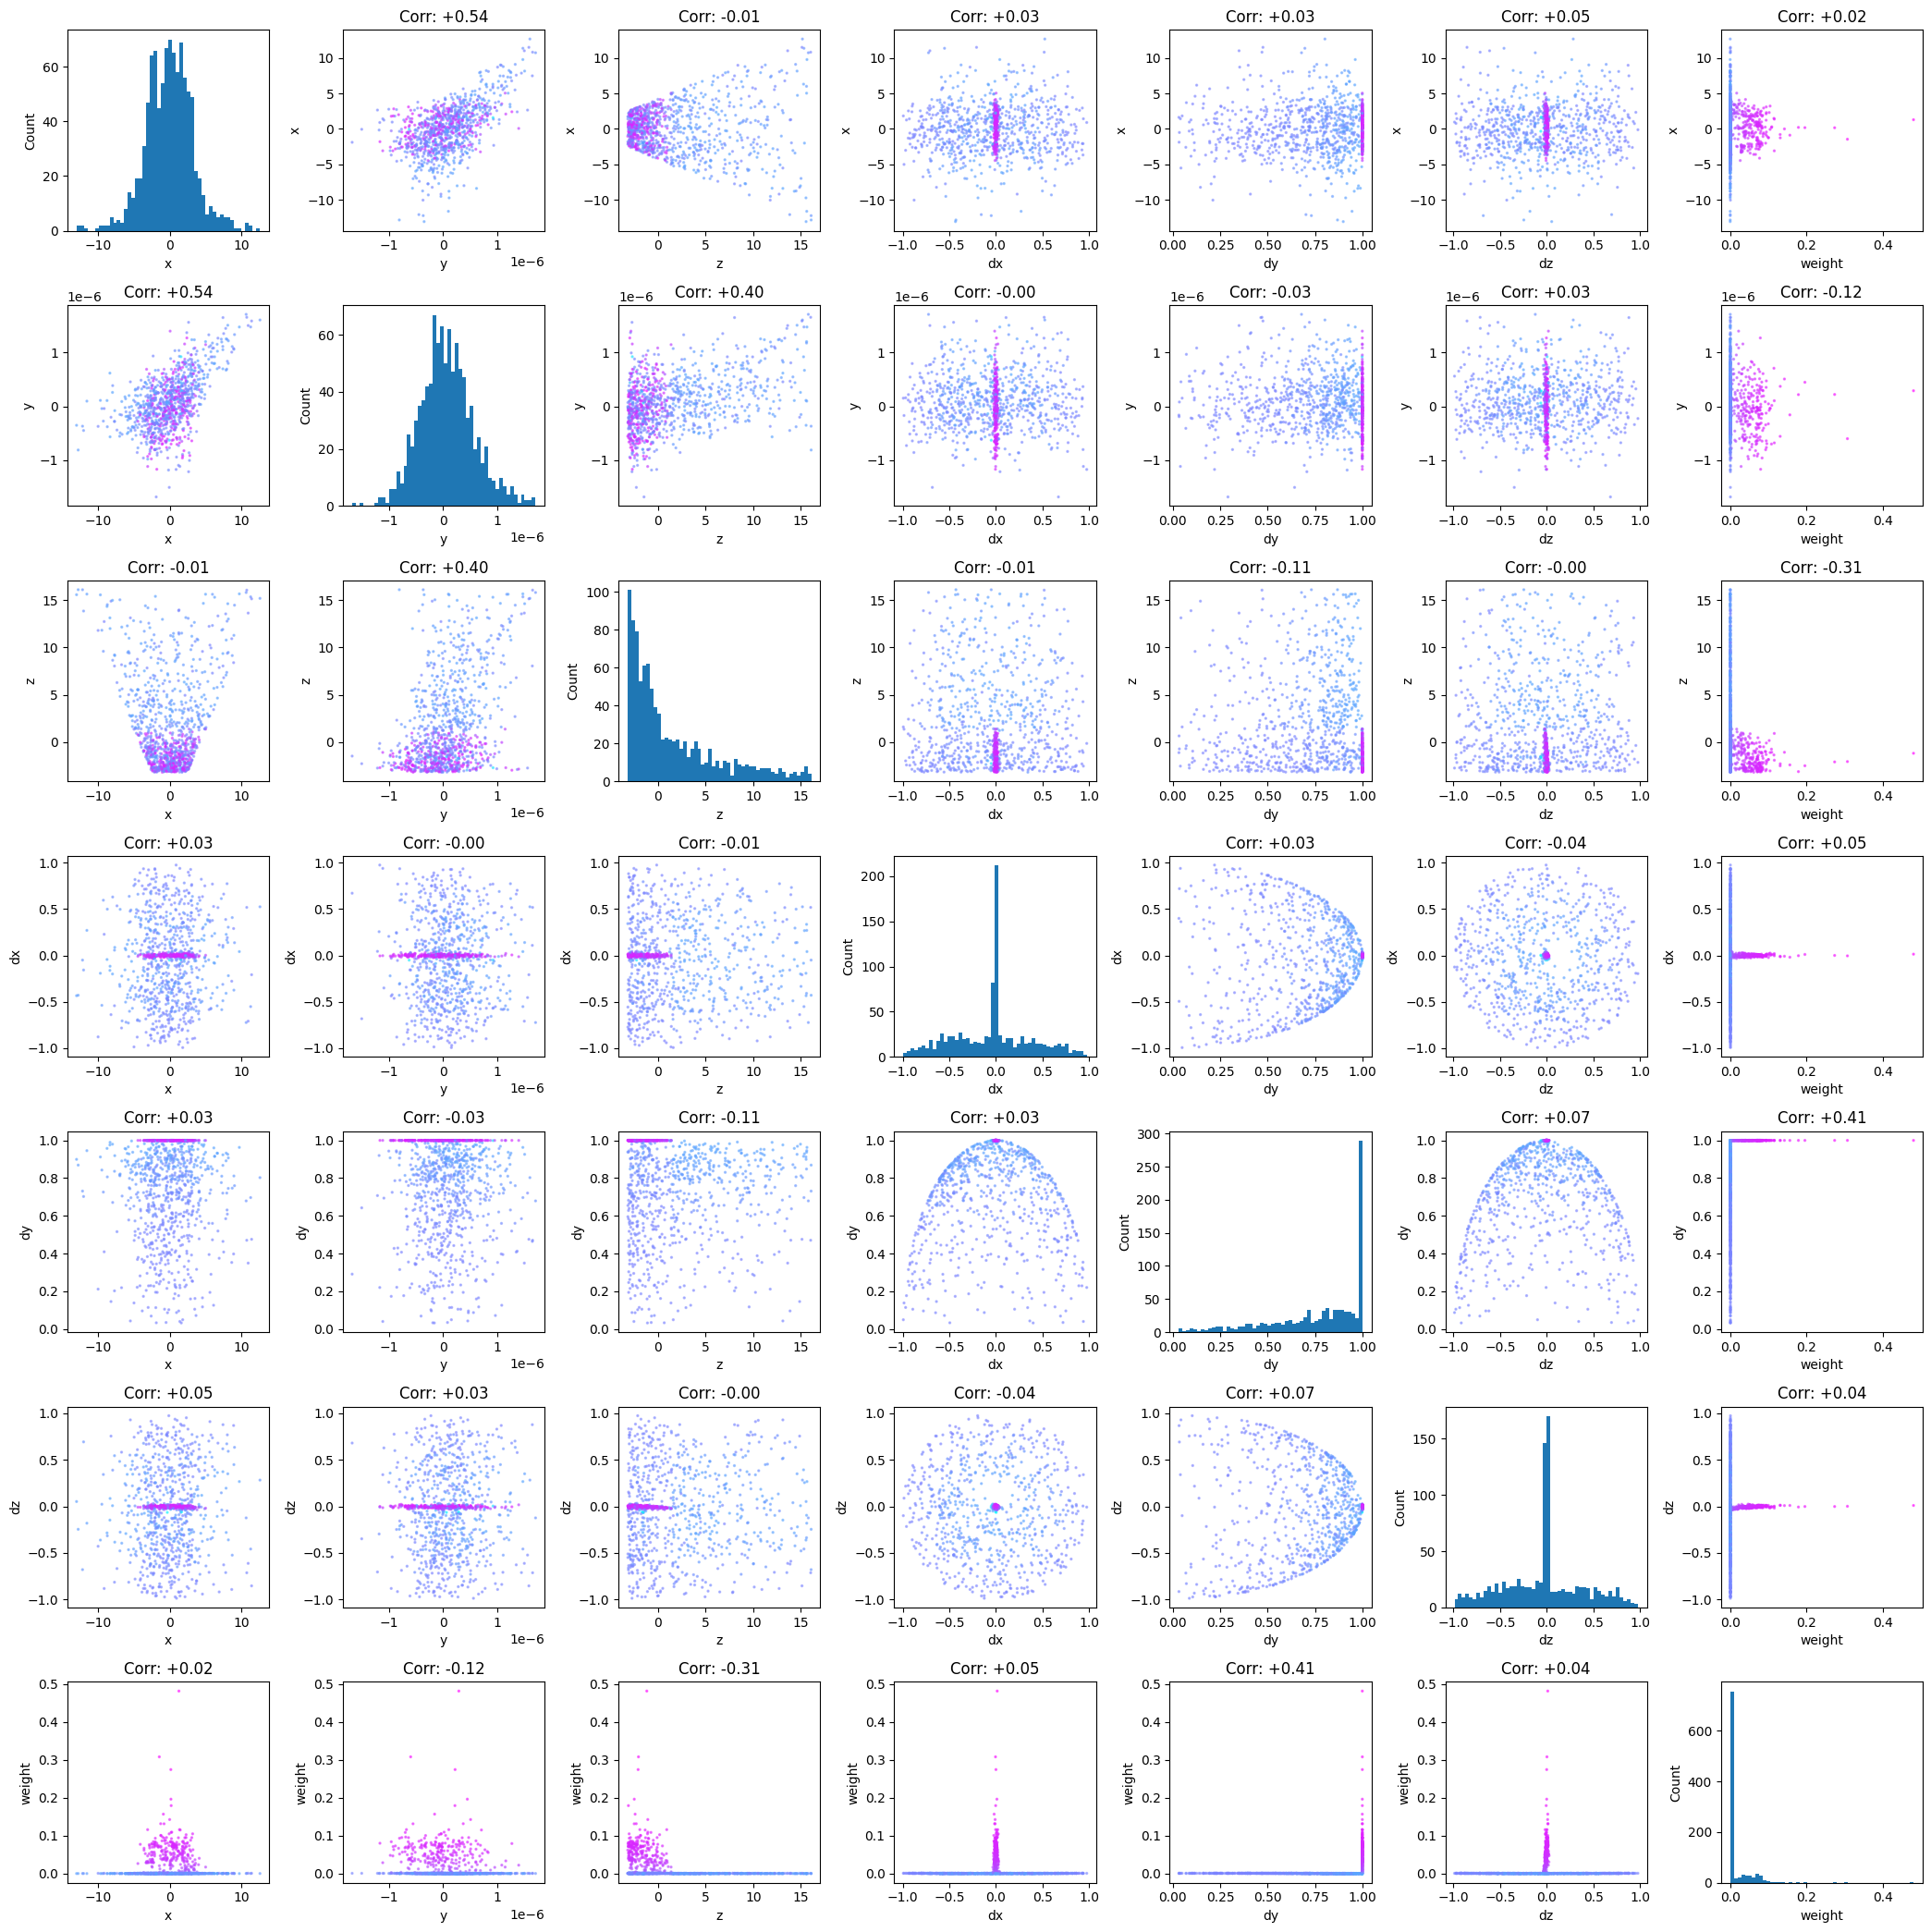

In [174]:
def plot_correlation(attributes: list, names: list, weight):
    ndim = len(attributes)
    fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))
    for i in range(ndim):
        for j in range(ndim):
            ax = axes[i, j]
            if i == j:
                ax.hist(attributes[i], bins=50)
            else:
                ax.scatter(attributes[j], attributes[i], c=weight, s=2, alpha=0.5, cmap="cool", norm="log")
            ax.set_xlabel(names[j])
            if i == j:
                ax.set_ylabel("Count")
            else:
                ax.set_ylabel(names[i])
                correlation = np.corrcoef(attributes[i], attributes[j])[0, 1]
                ax.set_title(f"Corr: {correlation:+.2f}")
    plt.tight_layout()
    plt.show()


# Plot the correlation between attributes
spp = 2
# position, direction, weight = load_samples(f"{source_dir}/cbox-classic/cbox-classic-samples-vs3d", spp, 10000)
# p, d, w = select_roi(position, direction, weight, roi)
p, d, w = load_samples("/local/home/zhengfe/Thesis/PBRT-v4/results/vs+/plane/plane-shadow-samples-vs+_rel_d4_l32k", spp, 1000)
attributes = [p[:, 0], p[:, 1], p[:, 2], d[:, 0], d[:, 1], d[:, 2], w]
names = ["x", "y", "z", "dx", "dy", "dz", "weight"]
plot_correlation(attributes, names, w)

In [208]:
X = np.concatenate([d[:, [0, 1]]], axis=1)
cca = CCA(n_components=1).fit(X, w)
cca.x_weights_, np.corrcoef(cca.transform(X).flatten(), w)[0, 1]

(array([[0.079654  ],
        [0.99682257]]),
 0.4075888776123768)

In [111]:
# Find x such that |Sl|^2/|S|^2 Var[W | X < x] + |Sr|^2/|S|^2 Var[W | X >= x] is minimized
def find_split(x, w, x_str="", ax=None):
    N = len(x)
    min_samps_per_side = 16
    costs = np.full(N, np.inf)
    indices = np.argsort(x)
    x = x[indices]
    w = w[indices]
    for i in range(min_samps_per_side, N - min_samps_per_side):
        costs[i] = (i/N)**1 * np.var(w[:i], ddof=1) + (1 - i/N)**1 * np.var(w[i:], ddof=1)

    min_idx = np.argmin(costs)
    min_x = x[min_idx]
    min_cost = costs[min_idx]
    if len(x_str) > 0:
        print(f'Optimal {x_str}: {min_x}, cost: {min_cost}, left ratio: {min_idx / N}')

    if ax:
        ax.plot(x, costs)
        ax.axvline(min_x, color='r', linestyle='--')
        ax.set_xlabel(x_str)
        ax.set_ylabel(f'Cost({x_str})')
        ax.set_title(f'Cost Scanning {x_str}')

    return min_x, min_cost

Selected 369 samples
Best z split: 1.0570570570570572, cost: 0.5319441920008912, left ratio: 0.5582655826558266


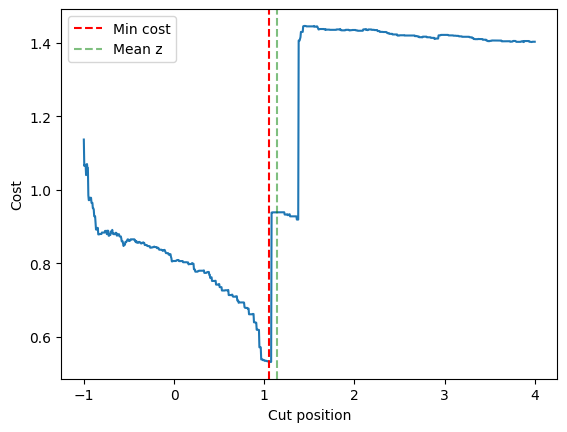

In [222]:
def weighted_variance(x, w):
    mean = np.average(x, weights=w)
    return np.average((x - mean) ** 2, weights=w)


# def split_cost(t, x, y, w=None):
#     # Calculate the cost of splitting at t, based on weighted variance of y
#     m = x < t
#     cl = weighted_variance(y[m], w[m]) if w is not None else np.var(y[m])
#     cr = weighted_variance(y[~m], w[~m]) if w is not None else np.var(y[~m])
#     return (np.sum(m)/len(x))**2 * cl + (np.sum(~m)/len(x))**2 * cr

# def split_cost(t, x, y0, y1, y2):
#     # Calculate the cost of splitting at t, based on weighted variance of y
#     gamma = 2
#     m = x < t
#     cl = np.var(y0[m]) + np.var(y1[m]) + np.var(y2[m])
#     cr = np.var(y0[~m]) + np.var(y1[~m]) + np.var(y2[~m])
#     return (np.sum(m)/len(x))**gamma * cl + (np.sum(~m)/len(x))**gamma * cr

def split_cost(t, x, y0, y1, y2, w):
    gamma = 0
    y = np.stack([y0, y1, y2], axis=1)
    m = x < t
    cca = CCA(n_components=1).fit(y[m], w[m])
    cl = np.abs(np.corrcoef(cca.transform(y[m]).flatten(), w[m])[0, 1])
    cca = CCA(n_components=1).fit(y[~m], w[~m])
    cr = np.abs(np.corrcoef(cca.transform(y[~m]).flatten(), w[~m])[0, 1])
    return (np.sum(m)/len(x))**gamma * cl + (np.sum(~m)/len(x))**gamma * cr


p_, d_, w_ = select_roi(p, d, w, np.array([[-5, 5], [-1, 1], [-1.1, 5.1]]))
indices = np.argsort(p_[:, 2])
p_, d_, w_ = p_[indices], d_[indices], w_[indices]
x, y, z = p_.T
dx, dy, dz = d_.T
t = np.linspace(-1, 4, 1000)
plt.figure()
# find_split(z, w_, "z", plt.gca())
# plt.show()
cost = [split_cost(ti, z, dx, dy, dz, w_) for ti in t]
plt.plot(t, cost)
best_t = t[np.argmin(cost)]
print(f"Best z split: {best_t}, cost: {np.min(cost)}, left ratio: {np.sum(z < best_t) / len(z)}")
plt.axvline(best_t, color='r', linestyle='--', label='Min cost')
plt.axvline(np.mean(z), color='g', linestyle='--', label='Mean z', alpha=0.5)
plt.xlabel("Cut position")
plt.ylabel("Cost")
plt.legend()
plt.show()

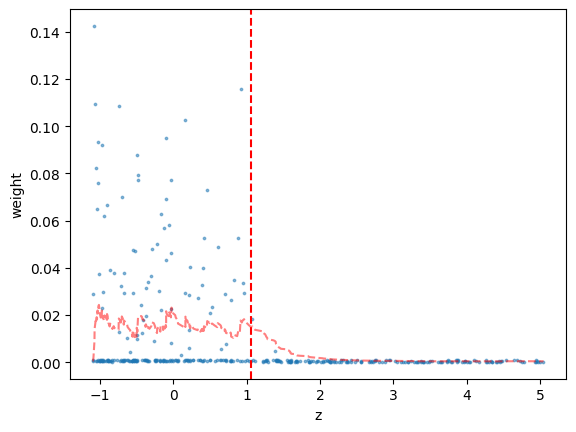

In [223]:
def exp_mean(x, a=0.8):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = a * y[i-1] + (1 - a) * x[i]
    return y

plt.figure()
plt.scatter(z, w_, s=3, alpha=0.5)
plt.plot(z, exp_mean(w_, 0.95), linestyle='--', color='r', alpha=0.5)
plt.axvline(best_t, color='r', linestyle='--', label='Min cost')
plt.xlabel("z")
plt.ylabel("weight")
plt.show()

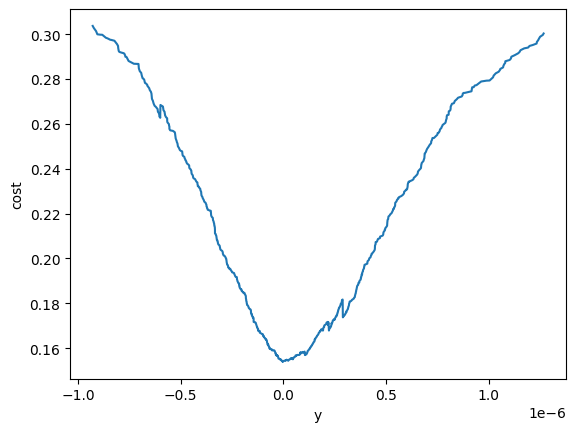

In [252]:
# Plot the correlation curve of w and (x, y, z) while scanning dim
def scan_correlation(p, w, dim):
    indices = np.argsort(p[:, dim])
    p = p[indices]
    w = w[indices]
    N = len(p)
    costs = np.full(N, np.inf)
    min_samples_per_side = 16
    gamma = 2
    for i in range(min_samples_per_side, N - min_samples_per_side):
        cca = CCA(n_components=1).fit(p[:i], w[:i])
        lc = np.abs(np.corrcoef(cca.transform(p[:i]).flatten(), w[:i])[0, 1])
        cca = CCA(n_components=1).fit(p[i:], w[i:])
        rc = np.abs(np.corrcoef(cca.transform(p[i:]).flatten(), w[i:])[0, 1])
        # lc = np.abs(np.corrcoef(p[:i, dim], w[:i])[0, 1])
        # rc = np.abs(np.corrcoef(p[i:, dim], w[i:])[0, 1])
        costs[i] = (i/N)**gamma * lc + (1 - i/N)**gamma * rc
    plt.figure()
    plt.plot(p[:, dim], costs)
    plt.xlabel("xyz"[dim])
    plt.ylabel("cost")
    plt.show()

scan_correlation(p, w, 1)